In [1]:
#!pip install datasets

In [2]:
#!pip install nltk

In [3]:
#!pip install openpyxl

In [4]:
!pip install transformers[torch]

# Reading the data

In [5]:
from datasets import get_dataset_config_names


configs = get_dataset_config_names("ealvaradob/phishing-dataset")
print("Available configurations:", configs)

c:\Users\salia\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available configurations: ['texts', 'urls', 'webs', 'combined_full', 'combined_reduced']


In [6]:
from datasets import load_dataset

# Choose one of these configurations:
configs = ['texts', 'urls', 'webs', 'combined_full', 'combined_reduced']

dataset = load_dataset("ealvaradob/phishing-dataset", "texts", trust_remote_code=True)

# Convert to pandas DataFrame
df = dataset['train'].to_pandas()
print(f"Loaded {len(df)} rows")
print(df.head())

Loaded 20137 rows
                                                text  label
0  re : 6 . 1100 , disc : uniformitarianism , re ...      0
1  the other side of * galicismos * * galicismo *...      0
2  re : equistar deal tickets are you still avail...      0
3  \nHello I am your hot lil horny toy.\n    I am...      1
4  software at incredibly low prices ( 86 % lower...      1


In [7]:
df.shape

(20137, 2)

## Looking at the data Imbalance

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20137 entries, 0 to 20136
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20137 non-null  object
 1   label   20137 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 314.8+ KB
None
label
0    0.61901
1    0.38099
Name: proportion, dtype: float64


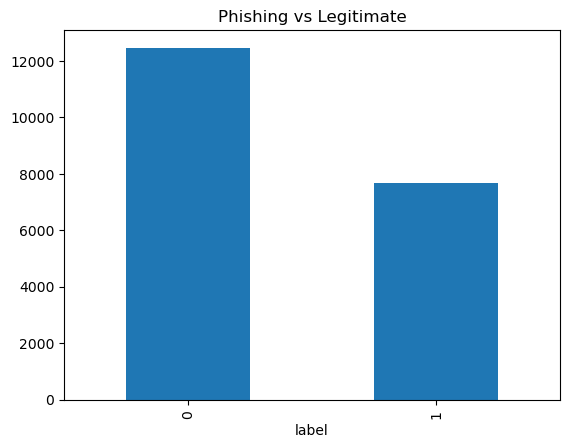

<Axes: >

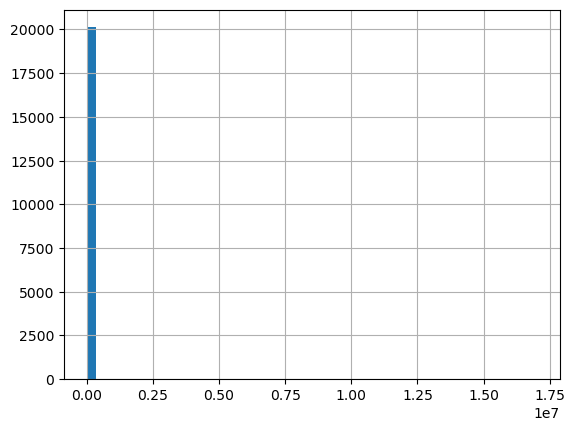

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Basic stats
print(df.info())
print(df['label'].value_counts(normalize=True))

# Visualize class balance
df['label'].value_counts().plot(kind='bar', title='Phishing vs Legitimate')
plt.show()

# Example: Check text length distribution
df['text_length'] = df['text'].apply(len)
df['text_length'].hist(bins=50)

## Looking at the examples

In [9]:
# Spot-check phishing examples
print("Phishing Examples:")
print(df[df['label'] == 1]['text'].sample(2).values)

# Spot-check legitimate examples
print("\nLegitimate Examples:")
print(df[df['label'] == 0]['text'].sample(2).values)

Phishing Examples:
['new member incentive program - get an apple computer !'
 "picks so hot you ' ll tell your friends stock watch alert this morning are wysak petroleum ( wysk ) , key energy services , inc . ( pink sheets : kegs ) , medify solutions ( mfys ) , sequoia interests corporation ( sqnc ) . wysak petroieum ( wysk ) current price : . 225 wysak petroieum announces the signing of a letter of intent with the european commission baltic renewabie energy centre ( ec brec ) to assist wysak petroleum in the development of the wysak wind power project . ec brec and wysak have signed a loi in respect to the deveiopment of a ful | - sized commercial wind power project in europe . this letter states that ec brec can support wysak in matters such as financia | structuring and investment , regulatory issues , government policies , negotiations , wind technologies , and other aspects reiating to wind power . about the wysak wind project this development wil | be up to a maximum 90 mw in siz

# Data Preprocessing 

Processing the data for model: lowercase, remove urls, remove hitml tags sepcial char/numsm remove stop words 

In [10]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special chars/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Feature Engineering 

adding text length and urgency word count

In [11]:
# Add text length as a feature
df['text_length'] = df['text'].apply(len)

# Add urgency word count
urgency_words = ['urgent', 'immediately', 'action required']
df['urgency_score'] = df['text'].apply(lambda x: sum(x.lower().count(word) for word in urgency_words))

In [12]:
df.columns


Index(['text', 'label', 'text_length', 'cleaned_text', 'urgency_score'], dtype='object')

# Model Training

In [13]:
# ======================
# 1. Environment Setup
# ======================
import torch
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from transformers import DistilBertTokenizerFast, Trainer, TrainingArguments
import matplotlib.pyplot as plt

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ======================
# 2. Phishing-Specific Text Enhancement
# ======================
def enhance_phishing_tags(text):
    phishing_indicators = {
        'urgency': ['urgent', 'immediately', 'verify', 'account', 'click'],
        'threats': ['suspend', 'terminate', 'locked', 'restrict'],
        'requests': ['update', 'confirm', 'information', 'password']
    }
    
    for category, words in phishing_indicators.items():
        for word in words:
            text = re.sub(rf'\b{word}\b', f'[PHISH_{category.upper()}_{word.upper()}]', text, flags=re.IGNORECASE)
    return text

# Apply to your cleaned_text
df['bert_text'] = df['cleaned_text'].apply(enhance_phishing_tags)

# Verify
print("\nSample enhanced text:")
print(df.loc[df['label']==1, 'bert_text'].iloc[0])

# ======================
# 3. Feature Scaling
# ======================
scaler = RobustScaler()
df[['text_length_scaled', 'urgency_scaled']] = scaler.fit_transform(
    df[['text_length', 'urgency_score']]
)

# ======================
# 4. Handle Class Imbalance
# ======================
class_weights = torch.tensor([
    len(df[df['label']==1]) / len(df),  # Weight for class 0 (legitimate)
    len(df[df['label']==0]) / len(df)   # Weight for class 1 (phishing)
]).to(device)

# ======================
# 5. Dataset Preparation
# ======================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

class PhishingDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, numeric_features):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=128)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
        self.numeric = torch.tensor(numeric_features.values, dtype=torch.float32)
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['numeric_features'] = self.numeric[idx]
        return item
    
    def __len__(self):
        return len(self.labels)

# Train/Val/Test Split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_dataset = PhishingDataset(
    train_df['bert_text'], 
    train_df['label'],
    train_df[['text_length_scaled', 'urgency_scaled']]
)

# ======================
# 6. Custom Phishing BERT
# ======================
from transformers import DistilBertPreTrainedModel, DistilBertModel
import torch.nn as nn

class PhishingBERT(DistilBertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.distilbert = DistilBertModel(config)
        self.numeric_proj = nn.Linear(2, config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size * 2, 2)
        self.dropout = nn.Dropout(0.1)
        
        # Custom initialization for phishing focus
        self.classifier.weight.data.normal_(mean=0.0, std=0.02)
        self.classifier.bias.data.zero_()
        
    def forward(self, input_ids, attention_mask, numeric_features, labels=None):
        # BERT embeddings
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        
        # Numeric features
        num_features = self.numeric_proj(numeric_features)
        
        # Combined representation
        combined = torch.cat((pooled_output, num_features), dim=1)
        logits = self.classifier(self.dropout(combined))
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))
            
        return {'loss': loss, 'logits': logits}

# Initialize
model = PhishingBERT.from_pretrained('distilbert-base-uncased')
model.to(device)

# ======================
# 7. Training Configuration
# ======================
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),
    logging_dir='./logs',
)

# Metrics
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {'f1': f1, 'precision': precision, 'recall': recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=PhishingDataset(
        val_df['bert_text'],
        val_df['label'],
        val_df[['text_length_scaled', 'urgency_scaled']]
    ),
    compute_metrics=compute_metrics,
)

# ======================
# 8. Train & Evaluate
# ======================
print("\nStarting training...")
trainer.train()

# Final evaluation
test_results = trainer.evaluate(PhishingDataset(
    test_df['bert_text'],
    test_df['label'],
    test_df[['text_length_scaled', 'urgency_scaled']]
))
print("\nTest Performance:")
print(f"F1: {test_results['eval_f1']:.3f}")
print(f"Precision: {test_results['eval_precision']:.3f}")
print(f"Recall: {test_results['eval_recall']:.3f}")



# ======================
# 9. Corrected Prediction Function
# ======================
def predict_example(text):
    """Fixed version handling both warnings and model outputs"""
    # 1. Clean and enhance text
    cleaned = clean_text(text)
    enhanced = enhance_phishing_tags(cleaned)
    
    # 2. Prepare numeric features (suppress feature name warning)
    urgency_count = sum(text.lower().count(w) for w in ['urgent','verify','click'])
    numeric_features = np.array([[len(text), urgency_count]])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        numeric_scaled = scaler.transform(numeric_features)
    
    # 3. Tokenize text
    inputs = tokenizer(enhanced, return_tensors="pt", truncation=True, max_length=128)
    
    # 4. Move to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    numeric_tensor = torch.tensor(numeric_scaled, dtype=torch.float32).to(device)
    
    # 5. Predict with model.eval() mode
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, numeric_features=numeric_tensor)
        logits = outputs['logits']  # Explicitly access logits from dict
        probs = torch.softmax(logits, dim=-1)
    
    return {
        "text": text,
        "processed_text": enhanced,
        "prediction": "Phishing" if probs.argmax() == 1 else "Legitimate",
        "phishing_prob": probs[0][1].item()
    }

# Test with proper error handling
import warnings
from sklearn.exceptions import DataConversionWarning

print("\n=== Corrected Prediction ===")
sample_phish = "URGENT: Your account will be SUSPENDED. Click NOW: https://fake.com/verify"
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DataConversionWarning)
    try:
        result = predict_example(sample_phish)
        print(f"Input: {result['text']}")
        print(f"Processed: {result['processed_text']}")
        print(f"Prediction: {result['prediction']} (confidence: {result['phishing_prob']:.2%})")
    except Exception as e:
        print(f"Prediction failed: {str(e)}")

Using device: cuda

Sample enhanced text:
hello hot lil horny toy one dream open minded person love talk subject fantasy way life ultimate sex play ummmmmmmmmmmmmm wet ready looks imagination matters sexy voice make dream come true hurry call let cummmmm tollfree teen phone billing signup free personalized email mailcom


Some weights of PhishingBERT were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'numeric_proj.bias', 'numeric_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\salia\anaconda3\envs\gpu_env\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Starting training...


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,No log,0.105196,0.956522,0.957354,0.955691
2,0.277500,0.166871,0.945323,0.984934,0.908775
3,0.077900,0.143930,0.962996,0.976765,0.949609
4,0.032600,0.176005,0.961131,0.977538,0.945265
5,0.020100,0.154101,0.964520,0.972615,0.956560



Test Performance:
F1: 0.965
Precision: 0.964
Recall: 0.966

=== Corrected Prediction ===
Input: URGENT: Your account will be SUSPENDED. Click NOW: https://fake.com/verify
Processed: [PHISH_URGENCY_URGENT] [PHISH_URGENCY_ACCOUNT] suspended [PHISH_URGENCY_CLICK]
Prediction: Phishing (confidence: 99.99%)


In [14]:
# Test with proper error handling
import warnings
from sklearn.exceptions import DataConversionWarning

print("\n=== Corrected Prediction ===")
sample_phish1 = "Thanks Kartik – Ill discuss with the team next week  Dee Houlihan Sr. Technical Recruiter EMEA M: + 353 (0)87 1422788  | dhoulihan@proofpoint.com Proofpoint Inc., Cork, Ireland."
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DataConversionWarning)
    try:
        result = predict_example(sample_phish1)
        print(f"Input: {result['text']}")
        print(f"Processed: {result['processed_text']}")
        print(f"Prediction: {result['prediction']} (confidence: {result['phishing_prob']:.2%})")
    except Exception as e:
        print(f"Prediction failed: {str(e)}")


=== Corrected Prediction ===
Input: Thanks Kartik – Ill discuss with the team next week  Dee Houlihan Sr. Technical Recruiter EMEA M: + 353 (0)87 1422788  | dhoulihan@proofpoint.com Proofpoint Inc., Cork, Ireland.
Processed: thanks kartik ill discuss team next week dee houlihan sr technical recruiter emea dhoulihanproofpointcom proofpoint inc cork ireland
Prediction: Legitimate (confidence: 0.02%)


In [ ]:
# ======================
# 9. Save Pipeline (Fixed Version)
# ======================
import joblib
from transformers import DistilBertTokenizerFast

def save_pipeline_safely(model, tokenizer, scaler, clean_text_func, enhance_tags_func, path='./phishing_pipeline'):
    """
    Safely saves the complete pipeline without changing your existing code structure
    """
    import os
    import tempfile
    import shutil
    
    # Create temp directory
    temp_dir = tempfile.mkdtemp()
    final_path = os.path.abspath(path)
    
    try:
        print("\nSaving pipeline components...")
        
        # 1. Save model weights separately (PyTorch recommended way)
        model_path = os.path.join(temp_dir, 'model_weights.pt')
        torch.save(model.state_dict(), model_path)
        print(f"- Model weights saved to {model_path}")
        
        # 2. Save tokenizer (transformers native way)
        tokenizer_path = os.path.join(temp_dir, 'tokenizer')
        tokenizer.save_pretrained(tokenizer_path)
        print(f"- Tokenizer saved to {tokenizer_path}")
        
        # 3. Save other components (joblib)
        pipeline_assets = {
            'scaler': scaler,
            'clean_text': clean_text_func,
            'enhance_phishing_tags': enhance_tags_func,
            'class_names': ['Legitimate', 'Phishing']
        }
        assets_path = os.path.join(temp_dir, 'pipeline_assets.joblib')
        joblib.dump(pipeline_assets, assets_path)
        print(f"- Pipeline assets saved to {assets_path}")
        
        # 4. Create version file
        with open(os.path.join(temp_dir, 'version.info'), 'w') as f:
            f.write("phishing-detection-pipeline-v1.0")
        
        # 5. Atomic move to final location
        if os.path.exists(final_path):
            shutil.rmtree(final_path)
        shutil.move(temp_dir, final_path)
        
        print(f"\nPipeline successfully saved to: {final_path}")
        return True
        
    except Exception as e:
        print(f"\nFailed to save pipeline: {str(e)}")
        shutil.rmtree(temp_dir, ignore_errors=True)
        return False



In [ ]:
# ======================
# 10. Save the Complete Pipeline
# ======================
# Define all components to save
save_success = save_pipeline_safely(
    model=model,                      # Your trained PhishingBERT model
    tokenizer=tokenizer,              # DistilBertTokenizerFast instance
    scaler=scaler,                    # Fitted RobustScaler
    clean_text_func=clean_text,       # Your text cleaning function
    enhance_tags_func=enhance_phishing_tags,  # Your phishing tag enhancement function
    path='' # Output folder name
)

if save_success:
    print("\n✅ Pipeline saved successfully!")
else:
    print("\n❌ Pipeline saving failed")
    phishing_detector_pipeline


Saving pipeline components...
- Model weights saved to C:\Users\salia\AppData\Local\Temp\tmp3siw3j_f\model_weights.pt
- Tokenizer saved to C:\Users\salia\AppData\Local\Temp\tmp3siw3j_f\tokenizer
- Pipeline assets saved to C:\Users\salia\AppData\Local\Temp\tmp3siw3j_f\pipeline_assets.joblib

Failed to save pipeline: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\salia\\Documents\\NLP'

❌ Pipeline saving failed
